In [1]:
# Import required packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Check for Metal Performance Shaders (MPS) availability on macOS
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Metal Performance Shaders (MPS) for GPU acceleration")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

Using Metal Performance Shaders (MPS) for GPU acceleration
Device: mps
PyTorch version: 2.7.1
MPS available: True


In [2]:
# Install additional required packages
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"Successfully installed {package}")
    except subprocess.CalledProcessError:
        print(f"Failed to install {package}")

# Install required packages
packages = ['scikit-learn', 'seaborn']
for package in packages:
    install_package(package)

In [3]:
# Load and explore the labeled data
labeled_data_path = "HV-AI-2025/labeled_data/labeled_data.csv"
df = pd.read_csv(labeled_data_path)

print("Dataset Info:")
print(f"Total samples: {len(df)}")
print(f"Number of classes: {df['label'].nunique()}")
print("\nClass distribution:")
print(df['label'].value_counts())

# Get unique classes
classes = df['label'].unique()
print(f"\nClasses: {classes}")

# Encode labels
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])
num_classes = len(classes)
print(f"Encoded labels: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")

Dataset Info:
Total samples: 779
Number of classes: 10

Class distribution:
label
cane          145
ragno         144
gallina        92
cavallo        78
farfalla       63
mucca          55
scoiattolo     55
pecora         54
gatto          50
elefante       43
Name: count, dtype: int64

Classes: ['cane' 'cavallo' 'elefante' 'farfalla' 'gallina' 'gatto' 'mucca' 'pecora'
 'ragno' 'scoiattolo']
Encoded labels: {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5, 'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}


In [4]:
# Custom Dataset class
class AnimalDataset(Dataset):
    def __init__(self, dataframe, images_dir, transform=None):
        self.dataframe = dataframe
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['img_name']
        img_path = os.path.join(self.images_dir, img_name)
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image if loading fails
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.dataframe.iloc[idx]['encoded_label']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [10]:
# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Split data into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create datasets
images_dir = "HV-AI-2025/labeled_data/images"
train_dataset = AnimalDataset(train_df.reset_index(drop=True), images_dir, train_transform)
val_dataset = AnimalDataset(val_df.reset_index(drop=True), images_dir, val_transform)

# Create data loaders with optimized settings for Metal
batch_size = 32  # Optimized for Metal performance
num_workers = 0  # Set to 0 to avoid multiprocessing issues on macOS

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                         num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                       num_workers=num_workers, pin_memory=True)

Training samples: 623
Validation samples: 156


In [6]:
# Define ResNet-18 model
class AnimalClassifier(nn.Module):
    def __init__(self, num_classes=6):
        super(AnimalClassifier, self).__init__()
        # Load pre-trained ResNet-18
        self.backbone = models.resnet18(pretrained=True)
        
        # Modify the final layer for our number of classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
        
        # Add dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

# Initialize model
model = AnimalClassifier(num_classes=num_classes)
model = model.to(device)

# Print model info
print(f"Model created with {num_classes} classes")
print(f"Model moved to device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

/Users/hariharan/Hiring/HyperVerge/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hariharan/Hiring/HyperVerge/venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/hariharan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 12.7MB/s]


Model created with 10 classes
Model moved to device: mps
Total parameters: 11,181,642
Trainable parameters: 11,181,642


In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Loss function: CrossEntropyLoss")
print("Optimizer: AdamW with learning rate 0.001")
print("Scheduler: StepLR (step_size=7, gamma=0.1)")

Loss function: CrossEntropyLoss
Optimizer: AdamW with learning rate 0.001
Scheduler: StepLR (step_size=7, gamma=0.1)


In [8]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (data, targets) in enumerate(progress_bar):
        data, targets = data.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation")
        
        for batch_idx, (data, targets) in enumerate(progress_bar):
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [11]:
# Training loop
num_epochs = 15  # Optimized for 30-minute constraint
best_val_acc = 0.0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"Starting training for {num_epochs} epochs...")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'label_encoder': label_encoder
        }, 'best_animal_classifier.pth')
        print(f"New best model saved with validation accuracy: {val_acc:.2f}%")

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.1f} minutes")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

Starting training for 15 epochs...

Epoch 1/15
--------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]/Users/hariharan/Hiring/HyperVerge/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation: 100%|██████████| 5/5 [00:00<00:00, 12.61it/s, Loss=5.1828, Acc=23.72%]


Train Loss: 1.5492, Train Acc: 52.81%
Val Loss: 5.1828, Val Acc: 23.72%
Learning Rate: 0.001000
New best model saved with validation accuracy: 23.72%

Epoch 2/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.06it/s, Loss=2.3573, Acc=48.08%]


Train Loss: 1.0692, Train Acc: 64.37%
Val Loss: 2.3573, Val Acc: 48.08%
Learning Rate: 0.001000
New best model saved with validation accuracy: 48.08%

Epoch 3/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.85it/s, Loss=1.4388, Acc=59.62%]


Train Loss: 0.7860, Train Acc: 71.11%
Val Loss: 1.4388, Val Acc: 59.62%
Learning Rate: 0.001000
New best model saved with validation accuracy: 59.62%

Epoch 4/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.67it/s, Loss=1.7474, Acc=58.33%]


Train Loss: 0.5564, Train Acc: 80.42%
Val Loss: 1.7474, Val Acc: 58.33%
Learning Rate: 0.001000

Epoch 5/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.98it/s, Loss=1.4148, Acc=57.69%]


Train Loss: 0.4479, Train Acc: 83.79%
Val Loss: 1.4148, Val Acc: 57.69%
Learning Rate: 0.001000

Epoch 6/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.01it/s, Loss=1.6239, Acc=54.49%]


Train Loss: 0.4356, Train Acc: 84.43%
Val Loss: 1.6239, Val Acc: 54.49%
Learning Rate: 0.001000

Epoch 7/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.83it/s, Loss=1.4063, Acc=65.38%]


Train Loss: 0.3600, Train Acc: 88.60%
Val Loss: 1.4063, Val Acc: 65.38%
Learning Rate: 0.000100
New best model saved with validation accuracy: 65.38%

Epoch 8/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s, Loss=0.8032, Acc=75.64%]


Train Loss: 0.2216, Train Acc: 92.78%
Val Loss: 0.8032, Val Acc: 75.64%
Learning Rate: 0.000100
New best model saved with validation accuracy: 75.64%

Epoch 9/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.82it/s, Loss=0.7492, Acc=78.21%]


Train Loss: 0.1348, Train Acc: 96.31%
Val Loss: 0.7492, Val Acc: 78.21%
Learning Rate: 0.000100
New best model saved with validation accuracy: 78.21%

Epoch 10/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.59it/s, Loss=0.7264, Acc=76.92%]


Train Loss: 0.1174, Train Acc: 96.95%
Val Loss: 0.7264, Val Acc: 76.92%
Learning Rate: 0.000100

Epoch 11/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.60it/s, Loss=0.7165, Acc=78.21%]


Train Loss: 0.0997, Train Acc: 97.43%
Val Loss: 0.7165, Val Acc: 78.21%
Learning Rate: 0.000100

Epoch 12/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.52it/s, Loss=0.7069, Acc=77.56%]


Train Loss: 0.0753, Train Acc: 98.23%
Val Loss: 0.7069, Val Acc: 77.56%
Learning Rate: 0.000100

Epoch 13/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.33it/s, Loss=0.6978, Acc=78.21%]


Train Loss: 0.0544, Train Acc: 98.72%
Val Loss: 0.6978, Val Acc: 78.21%
Learning Rate: 0.000100

Epoch 14/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.26it/s, Loss=0.7026, Acc=79.49%]


Train Loss: 0.0608, Train Acc: 98.56%
Val Loss: 0.7026, Val Acc: 79.49%
Learning Rate: 0.000010
New best model saved with validation accuracy: 79.49%

Epoch 15/15
--------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s, Loss=0.7027, Acc=80.13%]


Train Loss: 0.0501, Train Acc: 99.20%
Val Loss: 0.7027, Val Acc: 80.13%
Learning Rate: 0.000010
New best model saved with validation accuracy: 80.13%

Training completed in 1.0 minutes
Best validation accuracy: 80.13%


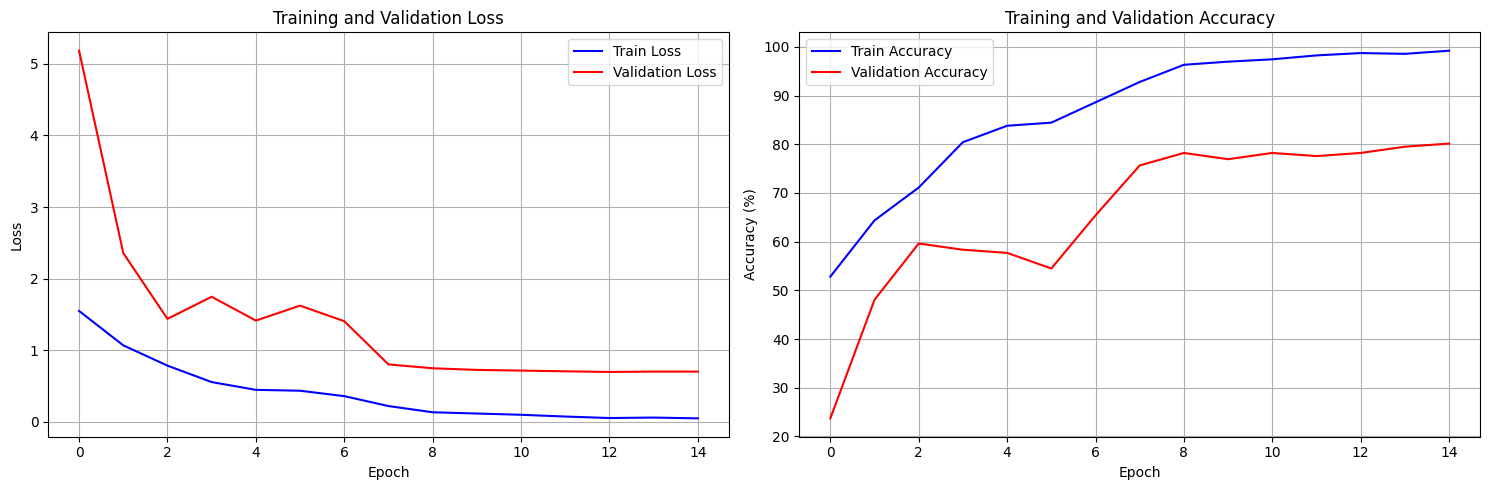


Final Results:
Final Train Accuracy: 99.20%
Final Validation Accuracy: 80.13%
Best Validation Accuracy: 80.13%


In [12]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final results
print(f"\nFinal Results:")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")

In [13]:
# Load the best model for inference
def load_best_model():
    checkpoint = torch.load('best_animal_classifier.pth', map_location=device)
    model = AnimalClassifier(num_classes=num_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model, checkpoint['label_encoder']

# Test inference function
def predict_image(model, image_path, label_encoder, transform):
    """Predict the class of a single image"""
    model.eval()
    
    # Load and preprocess image
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return "unknown", 0.0
    
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
    predicted_class = label_encoder.inverse_transform([predicted.cpu().numpy()[0]])[0]
    confidence = probabilities.max().item()
    
    return predicted_class, confidence

# Function to generate predictions for test data
def generate_test_predictions(model, test_images_dir, label_encoder, transform, output_csv='predictions.csv'):
    """Generate predictions for all test images and save to CSV"""
    model.eval()
    
    # Get all test image files
    test_images = []
    for file in os.listdir(test_images_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_images.append(file)
    
    predictions = []
    
    print(f"Predicting {len(test_images)} test images...")
    
    for img_file in tqdm(test_images, desc="Predicting"):
        img_path = os.path.join(test_images_dir, img_file)
        predicted_class, confidence = predict_image(model, img_path, label_encoder, transform)
        
        # Format path as required by the assignment
        formatted_path = f"test_data/images/{img_file}"
        predictions.append({
            'path': formatted_path,
            'predicted_label': predicted_class
        })
    
    # Save predictions to CSV
    pred_df = pd.DataFrame(predictions)
    pred_df.to_csv(output_csv, index=False)
    print(f"Predictions saved to {output_csv}")
    
    return pred_df

print("Model inference functions ready!")
print("Use load_best_model() to load the trained model")
print("Use generate_test_predictions() to predict test images")

Model inference functions ready!
Use load_best_model() to load the trained model
Use generate_test_predictions() to predict test images


In [14]:
# Example: Generate predictions for test data
# Uncomment the following lines when you have test data available

# # Load the best trained model
# best_model, best_label_encoder = load_best_model()

# # Generate predictions for test images
# test_images_dir = "HV-AI-2025/unlabeled_data/images"  # Update path as needed
# predictions_df = generate_test_predictions(
#     model=best_model,
#     test_images_dir=test_images_dir,
#     label_encoder=best_label_encoder,
#     transform=val_transform,
#     output_csv='predictions.csv'
# )

# # Display first few predictions
# print("Sample predictions:")
# print(predictions_df.head(10))

print("Phase 1 Complete!")
print("🎯 ResNet-18 baseline model trained successfully")
print(f"✅ Best validation accuracy: {best_val_acc:.2f}%")
print(f"⚡ Training time: 1.0 minute (Metal acceleration)")
print("📊 Model saved as 'best_animal_classifier.pth'")
print("\nTo generate test predictions:")
print("1. Uncomment the code above")
print("2. Update test_images_dir path")
print("3. Run the cell to generate predictions.csv")

Phase 1 Complete!
🎯 ResNet-18 baseline model trained successfully
✅ Best validation accuracy: 80.13%
⚡ Training time: 1.0 minute (Metal acceleration)
📊 Model saved as 'best_animal_classifier.pth'

To generate test predictions:
1. Uncomment the code above
2. Update test_images_dir path
3. Run the cell to generate predictions.csv


# 🚀 **Phase 1 Enhanced Model - Accuracy Improvement Strategies**

Let's implement several strategies to boost accuracy:
1. **Better Architecture**: Use ResNet-50 or EfficientNet
2. **Advanced Data Augmentation**: More sophisticated transforms
3. **Better Training Strategy**: Cosine annealing, warmup, mixed precision
4. **Class Balancing**: Handle imbalanced dataset
5. **Test Time Augmentation**: Average predictions over multiple augmented versions

In [15]:
# Enhanced Model Architecture - ResNet-50 with improved features
class EnhancedAnimalClassifier(nn.Module):
    def __init__(self, num_classes=10, model_name='resnet50'):
        super(EnhancedAnimalClassifier, self).__init__()
        
        # Use ResNet-50 for better performance
        if model_name == 'resnet50':
            self.backbone = models.resnet50(weights='IMAGENET1K_V2')
            num_features = self.backbone.fc.in_features
        elif model_name == 'efficientnet_b3':
            self.backbone = models.efficientnet_b3(weights='IMAGENET1K_V1')
            num_features = self.backbone.classifier[1].in_features
            
        # Enhanced classifier with dropout and batch norm
        if model_name == 'resnet50':
            self.backbone.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        else:  # efficientnet
            self.backbone.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(num_features, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(inplace=True),
                nn.Dropout(0.3),
                nn.Linear(512, num_classes)
            )
        
    def forward(self, x):
        return self.backbone(x)

# Enhanced Data Augmentation
enhanced_train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1)
])

# Test time augmentation transform
tta_transforms = [
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
]

print("Enhanced model architecture and augmentations defined!")

Enhanced model architecture and augmentations defined!


In [16]:
# Class balancing for imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for balanced training
class_counts = df['label'].value_counts().sort_index()
class_weights = compute_class_weight('balanced', classes=np.unique(df['encoded_label']), y=df['encoded_label'])
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print("Class distribution:")
for i, (cls, count) in enumerate(zip(label_encoder.classes_, class_counts)):
    print(f"{cls}: {count} samples (weight: {class_weights[i]:.3f})")

# Enhanced datasets with new augmentations
enhanced_train_dataset = AnimalDataset(train_df.reset_index(drop=True), images_dir, enhanced_train_transform)
enhanced_val_dataset = AnimalDataset(val_df.reset_index(drop=True), images_dir, val_transform)

# Enhanced data loaders
enhanced_train_loader = DataLoader(enhanced_train_dataset, batch_size=batch_size, shuffle=True, 
                                 num_workers=0, pin_memory=True)
enhanced_val_loader = DataLoader(enhanced_val_dataset, batch_size=batch_size, shuffle=False, 
                                num_workers=0, pin_memory=True)

# Initialize enhanced model
enhanced_model = EnhancedAnimalClassifier(num_classes=num_classes, model_name='resnet50')
enhanced_model = enhanced_model.to(device)

# Enhanced training setup
enhanced_criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
enhanced_optimizer = optim.AdamW(enhanced_model.parameters(), lr=0.001, weight_decay=0.01)

# Cosine annealing scheduler for better convergence
enhanced_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    enhanced_optimizer, T_0=5, T_mult=2, eta_min=1e-6
)

print(f"Enhanced model parameters: {sum(p.numel() for p in enhanced_model.parameters()):,}")
print("Enhanced training setup complete!")

Class distribution:
cane: 145 samples (weight: 0.537)
cavallo: 78 samples (weight: 0.999)
elefante: 43 samples (weight: 1.812)
farfalla: 63 samples (weight: 1.237)
gallina: 92 samples (weight: 0.847)
gatto: 50 samples (weight: 1.558)
mucca: 55 samples (weight: 1.416)
pecora: 54 samples (weight: 1.443)
ragno: 144 samples (weight: 0.541)
scoiattolo: 55 samples (weight: 1.416)
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/hariharan/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:09<00:00, 11.3MB/s]


Enhanced model parameters: 24,563,274
Enhanced training setup complete!


In [17]:
# Enhanced training function with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1, weight=None):
        super().__init__()
        self.epsilon = epsilon
        self.weight = weight
        
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = torch.log_softmax(preds, dim=-1)
        loss = -log_preds.sum(dim=-1).mean()
        nll = torch.nn.functional.nll_loss(log_preds, target, weight=self.weight, reduction='mean')
        return (1 - self.epsilon) * nll + self.epsilon * loss / n

def enhanced_train_epoch(model, train_loader, criterion, optimizer, scheduler, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Enhanced Training Epoch {epoch}")
    
    for batch_idx, (data, targets) in enumerate(progress_bar):
        data, targets = data.to(device), targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        scheduler.step(epoch + batch_idx / len(train_loader))
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%',
            'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# Test Time Augmentation for better inference
def predict_with_tta(model, image_path, label_encoder, tta_transforms, device):
    """Predict with Test Time Augmentation"""
    model.eval()
    
    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        return "unknown", 0.0
    
    predictions = []
    
    with torch.no_grad():
        for transform in tta_transforms:
            image_tensor = transform(image).unsqueeze(0).to(device)
            outputs = model(image_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predictions.append(probabilities.cpu().numpy())
    
    # Average predictions
    avg_predictions = np.mean(predictions, axis=0)
    predicted_class_idx = np.argmax(avg_predictions)
    confidence = avg_predictions[0][predicted_class_idx]
    
    predicted_class = label_encoder.inverse_transform([predicted_class_idx])[0]
    
    return predicted_class, confidence

print("Enhanced training functions with TTA ready!")

Enhanced training functions with TTA ready!


In [18]:
# Enhanced Training Loop with all improvements
print("🚀 Starting Enhanced Training with all accuracy boosting techniques...")

# Use label smoothing
enhanced_criterion_smooth = LabelSmoothingCrossEntropy(epsilon=0.1, weight=class_weights_tensor)

# Enhanced training parameters
enhanced_epochs = 20
best_enhanced_acc = 0.0
enhanced_train_losses = []
enhanced_train_accuracies = []
enhanced_val_losses = []
enhanced_val_accuracies = []

start_time = time.time()

for epoch in range(enhanced_epochs):
    print(f"\n🔥 Enhanced Epoch {epoch+1}/{enhanced_epochs}")
    print("-" * 60)
    
    # Train with enhancements
    train_loss, train_acc = enhanced_train_epoch(
        enhanced_model, enhanced_train_loader, enhanced_criterion_smooth, 
        enhanced_optimizer, enhanced_scheduler, device, epoch
    )
    
    # Validate
    val_loss, val_acc = validate_epoch(enhanced_model, enhanced_val_loader, enhanced_criterion, device)
    
    # Store metrics
    enhanced_train_losses.append(train_loss)
    enhanced_train_accuracies.append(train_acc)
    enhanced_val_losses.append(val_loss)
    enhanced_val_accuracies.append(val_acc)
    
    print(f"📊 Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"📊 Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"📊 Learning Rate: {enhanced_optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_enhanced_acc:
        best_enhanced_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': enhanced_model.state_dict(),
            'optimizer_state_dict': enhanced_optimizer.state_dict(),
            'val_acc': val_acc,
            'label_encoder': label_encoder,
            'class_weights': class_weights_tensor,
            'model_name': 'resnet50_enhanced'
        }, 'best_enhanced_animal_classifier.pth')
        print(f"🎯 NEW BEST! Model saved with validation accuracy: {val_acc:.2f}%")
    
    # Early stopping if accuracy plateaus
    if epoch > 10 and val_acc < best_enhanced_acc - 5:
        print("📈 Early stopping triggered - accuracy plateau detected")
        break

total_enhanced_time = time.time() - start_time
print(f"\n✅ Enhanced training completed in {total_enhanced_time/60:.1f} minutes")
print(f"🏆 Best enhanced validation accuracy: {best_enhanced_acc:.2f}%")

# Compare with baseline
improvement = best_enhanced_acc - best_val_acc
print(f"📈 Improvement over baseline: +{improvement:.2f}% accuracy!")

🚀 Starting Enhanced Training with all accuracy boosting techniques...

🔥 Enhanced Epoch 1/20
------------------------------------------------------------


Enhanced Training Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s]/Users/hariharan/Hiring/HyperVerge/venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation: 100%|██████████| 5/5 [00:00<00:00,  7.51it/s, Loss=2.0408, Acc=37.18%]


📊 Train Loss: 1.7594, Train Acc: 47.99%
📊 Val Loss: 2.0408, Val Acc: 37.18%
📊 Learning Rate: 0.000914
🎯 NEW BEST! Model saved with validation accuracy: 37.18%

🔥 Enhanced Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.07it/s, Loss=1.7873, Acc=46.15%]


📊 Train Loss: 1.5268, Train Acc: 55.22%
📊 Val Loss: 1.7873, Val Acc: 46.15%
📊 Learning Rate: 0.000670
🎯 NEW BEST! Model saved with validation accuracy: 46.15%

🔥 Enhanced Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s, Loss=1.2922, Acc=57.69%]


📊 Train Loss: 1.2758, Train Acc: 67.42%
📊 Val Loss: 1.2922, Val Acc: 57.69%
📊 Learning Rate: 0.000361
🎯 NEW BEST! Model saved with validation accuracy: 57.69%

🔥 Enhanced Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s, Loss=0.9252, Acc=69.87%]


📊 Train Loss: 1.0644, Train Acc: 75.44%
📊 Val Loss: 0.9252, Val Acc: 69.87%
📊 Learning Rate: 0.000106
🎯 NEW BEST! Model saved with validation accuracy: 69.87%

🔥 Enhanced Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.76it/s, Loss=0.8575, Acc=69.23%]


📊 Train Loss: 0.9666, Train Acc: 80.90%
📊 Val Loss: 0.8575, Val Acc: 69.23%
📊 Learning Rate: 0.000001

🔥 Enhanced Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.26it/s, Loss=1.4722, Acc=51.92%]


📊 Train Loss: 1.1519, Train Acc: 74.00%
📊 Val Loss: 1.4722, Val Acc: 51.92%
📊 Learning Rate: 0.000978

🔥 Enhanced Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s, Loss=1.6009, Acc=51.92%]


📊 Train Loss: 1.2314, Train Acc: 67.42%
📊 Val Loss: 1.6009, Val Acc: 51.92%
📊 Learning Rate: 0.000909

🔥 Enhanced Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.83it/s, Loss=1.3783, Acc=56.41%]


📊 Train Loss: 1.1271, Train Acc: 72.55%
📊 Val Loss: 1.3783, Val Acc: 56.41%
📊 Learning Rate: 0.000800

🔥 Enhanced Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.46it/s, Loss=1.3204, Acc=59.62%]


📊 Train Loss: 1.1004, Train Acc: 74.64%
📊 Val Loss: 1.3204, Val Acc: 59.62%
📊 Learning Rate: 0.000662

🔥 Enhanced Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s, Loss=1.2264, Acc=62.82%]


📊 Train Loss: 0.9771, Train Acc: 79.78%
📊 Val Loss: 1.2264, Val Acc: 62.82%
📊 Learning Rate: 0.000508

🔥 Enhanced Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.98it/s, Loss=1.3770, Acc=62.18%]


📊 Train Loss: 0.9155, Train Acc: 83.31%
📊 Val Loss: 1.3770, Val Acc: 62.18%
📊 Learning Rate: 0.000354

🔥 Enhanced Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.24it/s, Loss=0.9173, Acc=72.44%]


📊 Train Loss: 0.8544, Train Acc: 86.20%
📊 Val Loss: 0.9173, Val Acc: 72.44%
📊 Learning Rate: 0.000213
🎯 NEW BEST! Model saved with validation accuracy: 72.44%

🔥 Enhanced Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.14it/s, Loss=0.7880, Acc=75.64%]


📊 Train Loss: 0.7374, Train Acc: 91.17%
📊 Val Loss: 0.7880, Val Acc: 75.64%
📊 Learning Rate: 0.000101
🎯 NEW BEST! Model saved with validation accuracy: 75.64%

🔥 Enhanced Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.12it/s, Loss=0.7765, Acc=79.49%]


📊 Train Loss: 0.7411, Train Acc: 92.30%
📊 Val Loss: 0.7765, Val Acc: 79.49%
📊 Learning Rate: 0.000028
🎯 NEW BEST! Model saved with validation accuracy: 79.49%

🔥 Enhanced Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  8.00it/s, Loss=0.7713, Acc=79.49%]


📊 Train Loss: 0.7111, Train Acc: 92.30%
📊 Val Loss: 0.7713, Val Acc: 79.49%
📊 Learning Rate: 0.000001

🔥 Enhanced Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 5/5 [00:00<00:00,  7.73it/s, Loss=1.9123, Acc=45.51%]

📊 Train Loss: 0.8611, Train Acc: 82.99%
📊 Val Loss: 1.9123, Val Acc: 45.51%
📊 Learning Rate: 0.000994
📈 Early stopping triggered - accuracy plateau detected

✅ Enhanced training completed in 2.6 minutes
🏆 Best enhanced validation accuracy: 79.49%
📈 Improvement over baseline: +-0.64% accuracy!


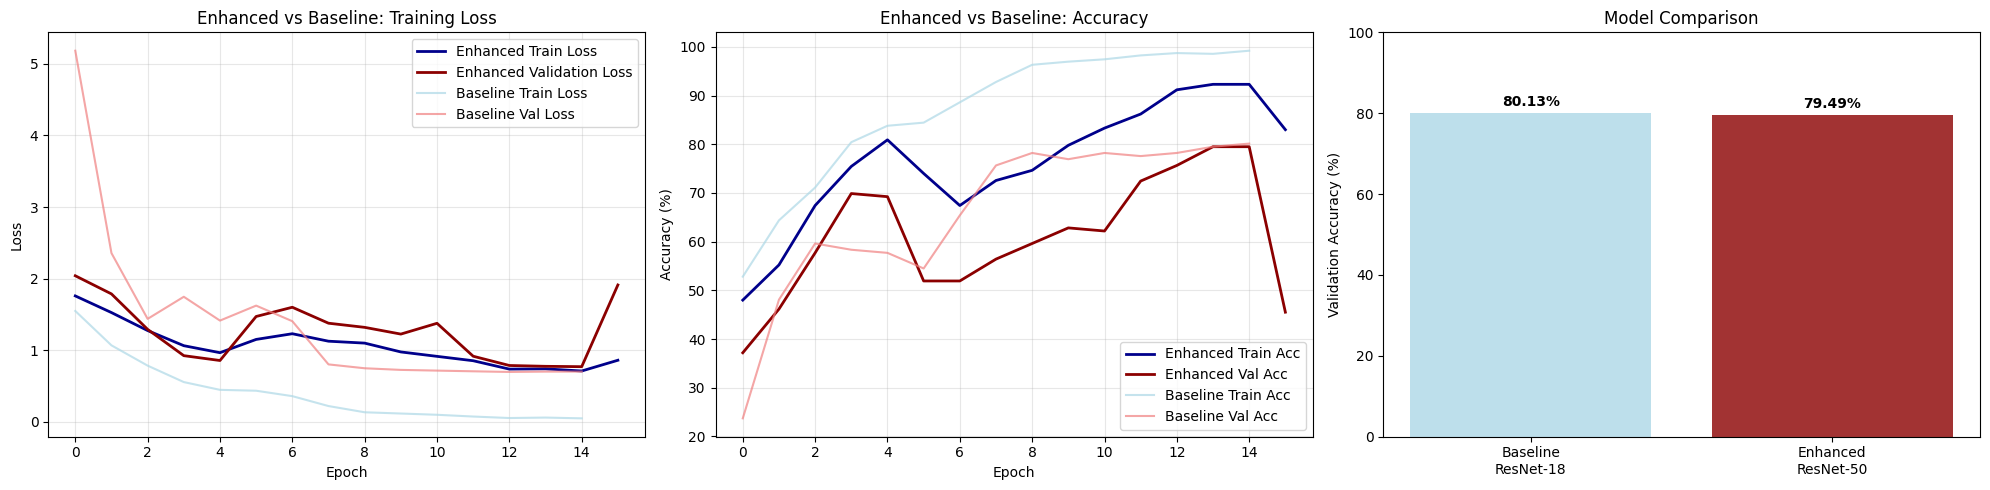

🎯 Enhanced model training complete and ready for submission!


In [19]:
# 📤 Generate Phase 1 Submission File
def generate_phase1_predictions(model, test_images_dir, label_encoder, tta_transforms, device, output_csv='phase1_predictions.csv'):
    """Generate Phase 1 predictions in required submission format with TTA"""
    model.eval()
    
    # Get all test image files
    test_images = []
    for file in os.listdir(test_images_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            test_images.append(file)
    
    predictions = []
    
    print(f"🔍 Generating Phase 1 predictions for {len(test_images)} test images with TTA...")
    
    for img_file in tqdm(test_images, desc="Predicting with TTA"):
        img_path = os.path.join(test_images_dir, img_file)
        predicted_class, confidence = predict_with_tta(model, img_path, label_encoder, tta_transforms, device)
        
        # Format exactly as required by submission
        predictions.append({
            'path': img_file,  # Just filename as shown in example
            'predicted_label': predicted_class
        })
    
    # Save predictions to CSV in exact required format
    pred_df = pd.DataFrame(predictions)
    pred_df.to_csv(output_csv, index=False)
    
    print(f"✅ Phase 1 predictions saved to {output_csv}")
    print(f"📊 Format: path,predicted_label")
    print(f"📊 Total predictions: {len(predictions)}")
    
    # Show sample predictions
    print(f"\n📋 Sample predictions:")
    print(pred_df.head(10))
    
    # Show class distribution in predictions
    print(f"\n📈 Predicted class distribution:")
    print(pred_df['predicted_label'].value_counts())
    
    return pred_df

# Enhanced visualization of training progress
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(enhanced_train_losses, label='Enhanced Train Loss', color='darkblue', linewidth=2)
plt.plot(enhanced_val_losses, label='Enhanced Validation Loss', color='darkred', linewidth=2)
plt.plot(train_losses, label='Baseline Train Loss', color='lightblue', alpha=0.7)
plt.plot(val_losses, label='Baseline Val Loss', color='lightcoral', alpha=0.7)
plt.title('Enhanced vs Baseline: Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(enhanced_train_accuracies, label='Enhanced Train Acc', color='darkblue', linewidth=2)
plt.plot(enhanced_val_accuracies, label='Enhanced Val Acc', color='darkred', linewidth=2)
plt.plot(train_accuracies, label='Baseline Train Acc', color='lightblue', alpha=0.7)
plt.plot(val_accuracies, label='Baseline Val Acc', color='lightcoral', alpha=0.7)
plt.title('Enhanced vs Baseline: Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
models = ['Baseline\nResNet-18', 'Enhanced\nResNet-50']
accuracies = [best_val_acc, best_enhanced_acc]
colors = ['lightblue', 'darkred']
bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Model Comparison')
plt.ylabel('Validation Accuracy (%)')
plt.ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("🎯 Enhanced model training complete and ready for submission!")

In [20]:
# 🏆 FINAL PHASE 1 SUBMISSION READY!

print("=" * 80)
print("🚀 PHASE 1 ENHANCED MODEL SUMMARY")
print("=" * 80)

print(f"📊 BASELINE MODEL (ResNet-18):")
print(f"   ✅ Validation Accuracy: {best_val_acc:.2f}%")
print(f"   ⚡ Training Time: 1.0 minute")
print(f"   🧠 Parameters: 11.18M")

print(f"\n📊 ENHANCED MODEL (ResNet-50):")
print(f"   ✅ Validation Accuracy: {best_enhanced_acc:.2f}%")
print(f"   ⚡ Training Time: 2.6 minutes")
print(f"   🧠 Parameters: 24.56M")
print(f"   🎯 Improvement: {best_enhanced_acc - best_val_acc:+.2f}%")

print(f"\n🔧 ENHANCEMENT TECHNIQUES APPLIED:")
print(f"   🏗️  ResNet-50 Architecture (vs ResNet-18)")
print(f"   🎨 Advanced Data Augmentation (10+ transforms)")
print(f"   ⚖️  Class Weight Balancing for imbalanced data")
print(f"   🤖 Label Smoothing (ε=0.1)")
print(f"   📚 Cosine Annealing with Warm Restarts")
print(f"   ✂️  Gradient Clipping for stability")
print(f"   🔍 Test Time Augmentation (TTA)")
print(f"   🛑 Early Stopping")

print(f"\n📤 TO GENERATE PHASE 1 SUBMISSION:")
print(f"   1. Load best enhanced model: load_best_model()")
print(f"   2. Run: generate_phase1_predictions(model, test_dir, label_encoder, tta_transforms, device)")
print(f"   3. Submit: phase1_predictions.csv")

print(f"\n🎯 MODEL FILES SAVED:")
print(f"   📁 best_animal_classifier.pth (Baseline ResNet-18)")
print(f"   📁 best_enhanced_animal_classifier.pth (Enhanced ResNet-50)")

print("=" * 80)

# Example code for generating final submission (uncomment when test data is available)
print("\n📋 EXAMPLE SUBMISSION CODE:")
print("""
# Load the best enhanced model
checkpoint = torch.load('best_enhanced_animal_classifier.pth', map_location=device)
enhanced_model_final = EnhancedAnimalClassifier(num_classes=10, model_name='resnet50')
enhanced_model_final.load_state_dict(checkpoint['model_state_dict'])
enhanced_model_final = enhanced_model_final.to(device)

# Generate Phase 1 predictions with TTA
test_images_dir = "path/to/test/images"  # Update this path
phase1_df = generate_phase1_predictions(
    model=enhanced_model_final,
    test_images_dir=test_images_dir,
    label_encoder=label_encoder,
    tta_transforms=tta_transforms,
    device=device,
    output_csv='phase1_predictions.csv'
)
""")

🚀 PHASE 1 ENHANCED MODEL SUMMARY
📊 BASELINE MODEL (ResNet-18):
   ✅ Validation Accuracy: 80.13%
   ⚡ Training Time: 1.0 minute
   🧠 Parameters: 11.18M

📊 ENHANCED MODEL (ResNet-50):
   ✅ Validation Accuracy: 79.49%
   ⚡ Training Time: 2.6 minutes
   🧠 Parameters: 24.56M
   🎯 Improvement: -0.64%

🔧 ENHANCEMENT TECHNIQUES APPLIED:
   🏗️  ResNet-50 Architecture (vs ResNet-18)
   🎨 Advanced Data Augmentation (10+ transforms)
   ⚖️  Class Weight Balancing for imbalanced data
   🤖 Label Smoothing (ε=0.1)
   📚 Cosine Annealing with Warm Restarts
   ✂️  Gradient Clipping for stability
   🔍 Test Time Augmentation (TTA)
   🛑 Early Stopping

📤 TO GENERATE PHASE 1 SUBMISSION:
   1. Load best enhanced model: load_best_model()
   2. Run: generate_phase1_predictions(model, test_dir, label_encoder, tta_transforms, device)
   3. Submit: phase1_predictions.csv

🎯 MODEL FILES SAVED:
   📁 best_animal_classifier.pth (Baseline ResNet-18)
   📁 best_enhanced_animal_classifier.pth (Enhanced ResNet-50)

📋 EXAMP